In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

/home/codespace/.conda/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 1.12.0
torchvision version: 0.13.0


# 1. Get Data

In [3]:
train_data = datasets.FashionMNIST(
    root = 'data',
    train=True,
    download = True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
image, label = train_data[0]
image[:1, :1, :1], label

(tensor([[[0.]]]), 9)

In [4]:
image.shape

torch.Size([1, 28, 28])

In [5]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

torch.Size([1, 28, 28])


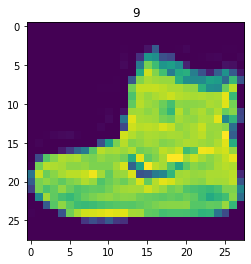

In [7]:
image, label = train_data[0]
print(image.shape)
plt.imshow(image.squeeze())
plt.title(label);
# plt.show()

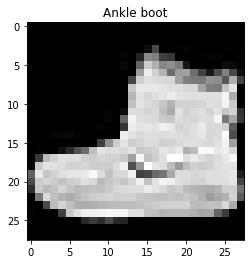

In [8]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label]);

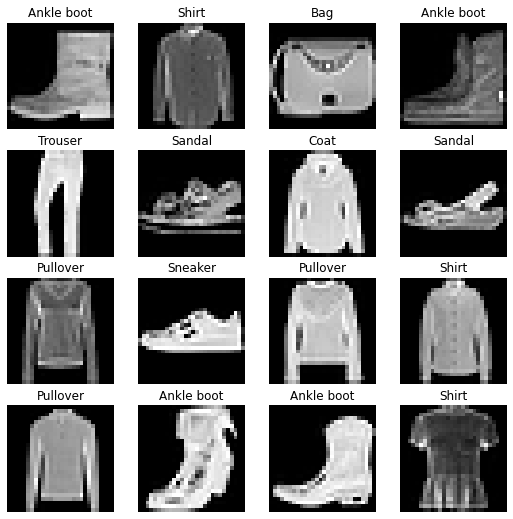

In [9]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))

rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]

    fig.add_subplot(rows, cols, i)

    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False);

# 2. Prepare DataLoader

In [5]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f2812c6a580>, <torch.utils.data.dataloader.DataLoader object at 0x7f2812c6a520>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [11]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


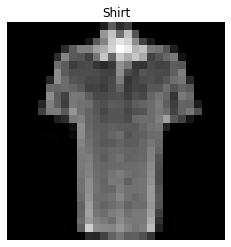

In [12]:
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img = train_features_batch[random_idx]
label = train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [13]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# print(x)
# print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [6]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# 3. Build a Baseline Model

In [15]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)
    

In [16]:
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model_0.parameters(),
    lr = 0.1
)

from torchmetrics import Accuracy

accuracy_fn = Accuracy(num_classes=len(class_names), multiclass=True).to(device)
type(accuracy_fn)

torchmetrics.classification.accuracy.Accuracy

In [18]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_preds = model_0(X)

        loss = loss_fn(y_preds, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)

    ### Evaluate model on test set
    test_loss, test_acc = 0, 0
    model_0.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)


    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:06<00:13,  6.91s/it]


Train loss: 0.59039 | Test loss: 0.50954, Test acc: 0.82%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:13<00:06,  6.78s/it]


Train loss: 0.47633 | Test loss: 0.47989, Test acc: 0.83%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:20<00:00,  6.70s/it]


Train loss: 0.45503 | Test loss: 0.47664, Test acc: 0.83%

Train time on cpu: 20.131 seconds


# 4. Make Predictions and get Model 0 results

In [14]:
torch.manual_seed(42)

def eval_model(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    acc_fn: Accuracy,
    device: torch.device = device
):
    """
    Returns a dictionary containing the results of a model predicting on a dataloader

    Args:
        model (torch.nn.Module): A PyTorch Model capable of making predictions on a dataloader
        dataloader (torch.utils.data.DataLoader): The target dataset to predict on
        loss_fn (torch.nn.Module): The loss function of the model
        acc_fn (torchmetrics.classification.accuracy.Accuracy): The Accuracy function of the model

    Returns:
        (dict): Results of a model predicting on a dataloader
    """

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device)
            y_preds = model(X)
            loss += loss_fn(y_preds, y)
            acc += acc_fn(y_preds.argmax(dim=1), y)

        loss /= len(dataloader)
        acc /= len(dataloader)

    return {
        'model_name': model.__class__.__name__,
        'loss': loss,
        'accuracy': acc
    }

# model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
# model_0_results

# 5. Setup Device Agnostic Code

And also write some code to functionize training an testing loop

In [7]:
import torch
from torch import nn
from torchmetrics import Accuracy
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
def train_step(
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    acc_fn: Accuracy,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device,
    ):

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        y_preds = model(X)

        loss = loss_fn(y_preds, y)
        train_loss += loss
        train_acc += acc_fn(y_preds.argmax(dim=1), y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    acc_fn: Accuracy,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device = device
    ): 
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device)

            test_preds = model(X)
            test_loss += loss_fn(test_preds, y)
            test_acc += acc_fn(test_preds.argmax(dim=1), y)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

        

# 6. Building a CNN Model

In [9]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),

            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1, 
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(
                hidden_units,
                hidden_units,
                3,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                hidden_units,
                hidden_units,
                3,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 7 * 7, output_shape)
        )
    
    def forward(self, x):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)

model_2 = FashionMNISTModelV1(
    input_shape = 1,
    hidden_units=10,
    output_shape = len(class_names)
).to(device)

model_2

FashionMNISTModelV1(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [10]:
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(num_classes=len(class_names), multiclass=True).to(device)
optimizer = torch.optim.SGD(model_2.parameters(),lr =0.1)

In [11]:
torch.manual_seed(42)
from tqdm import tqdm

from timeit import default_timer as timer

train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(
        model=model_2,
        loss_fn =loss_fn,
        dataloader =train_dataloader,
        acc_fn = accuracy_fn,
        optimizer=optimizer,
        device =device
    )
    test_step(
        model =model_2,
        loss_fn =loss_fn,
        acc_fn = accuracy_fn,
        dataloader =test_dataloader,
        device =device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59761 | Train accuracy: 0.78%


 33%|███▎      | 1/3 [00:23<00:47, 23.81s/it]

Test loss: 0.40072 | Test accuracy: 0.86%

Epoch: 1
---------
Train loss: 0.35661 | Train accuracy: 0.87%


 67%|██████▋   | 2/3 [00:43<00:21, 21.46s/it]

Test loss: 0.35493 | Test accuracy: 0.87%

Epoch: 2
---------
Train loss: 0.32155 | Train accuracy: 0.88%


100%|██████████| 3/3 [01:03<00:00, 21.19s/it]

Test loss: 0.32396 | Test accuracy: 0.88%

Train time on cpu: 63.571 seconds


In [15]:
model_2_results = eval_model(model_2, test_dataloader, loss_fn, accuracy_fn)
model_2_results

{'model_name': 'FashionMNISTModelV1',
 'loss': tensor(0.3240),
 'accuracy': tensor(0.8816)}

# 9. Make Predictions with Best Model

In [19]:
def make_predictions(
    model: torch.nn.Module,
    data: list,
    device: torch.device = device
):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [20]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [21]:
pred_probs = make_predictions(model_2, test_samples, device=device)
pred_probs[:2]

tensor([[1.8291e-08, 3.7965e-09, 2.1227e-09, 3.8055e-09, 1.5990e-09, 9.9987e-01,
         2.5694e-07, 6.5159e-07, 2.4513e-06, 1.2283e-04],
        [1.2688e-01, 4.2697e-01, 1.0966e-03, 1.4815e-01, 1.6906e-01, 5.8747e-05,
         1.2701e-01, 2.0458e-04, 2.3820e-04, 3.3128e-04]])

In [22]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [23]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

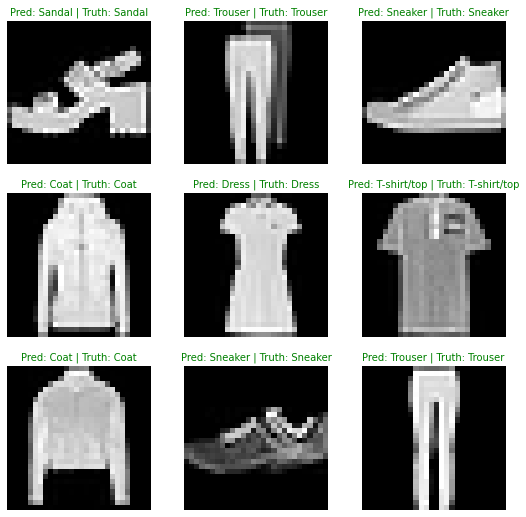

In [24]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [27]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
# print(y_pred_tensor)

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 185.73it/s]

tensor([9, 2, 1,  ..., 8, 1, 8])


In [28]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    %pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

Note: you may need to restart the kernel to use updated packages.
mlxtend version: 0.20.0


In [29]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.20.0


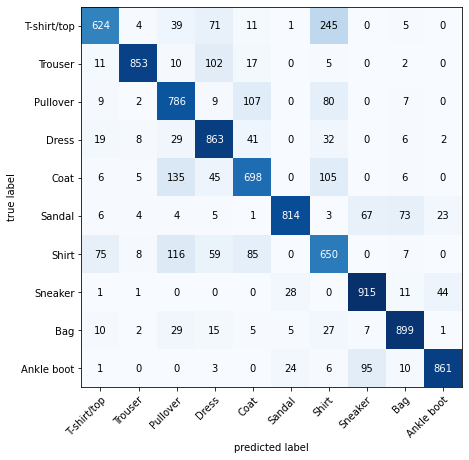

In [30]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [31]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [33]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV1(input_shape=1, 
                                    hidden_units=10, # try changing this to 128 and seeing what happens 
                                    output_shape=len(class_names)) 

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

In [37]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    dataloader=test_dataloader,
    loss_fn=loss_fn, 
    acc_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV1',
 'loss': tensor(0.3240),
 'accuracy': tensor(0.8816)}

In [38]:
model_2_results

{'model_name': 'FashionMNISTModelV1',
 'loss': tensor(0.3240),
 'accuracy': tensor(0.8816)}

In [41]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["loss"]), 
              torch.tensor(loaded_model_2_results["loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

/tmp/ipykernel_10774/4156802545.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.isclose(torch.tensor(model_2_results["loss"]),
/tmp/ipykernel_10774/4156802545.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(loaded_model_2_results["loss"]),


tensor(True)

: 